In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob 
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats

# Not safe!
import warnings
warnings.filterwarnings('ignore')

homfam_af2_scores  = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam_ref/01_AF2_SCORES_irsmd.csv")

def get_summary_lib(library):
    file1 = open(library, 'r')
    Lines = file1.readlines()


    count = 0
    header_finished = False

    seq_indexes = pd.DataFrame()
    residues = pd.DataFrame()

    # Strips the newline character
    for line in Lines:
        if line.startswith("!"):
            count += 1
            continue
        if count == 0:
            count += 1
            continue
        elif count == 1: 
            nseq = int(line)
            count += 1
            continue
        elif count == nseq+2: 
            header_finished = True

        if not header_finished: 
            count += 1
            # ----- PARSE INDEXES SEQUENCES 
            seq_id = line.split()[0]
            seq = line.split()[2]
            idx_seq = count-2
            entry = pd.DataFrame({"index":[idx_seq], "seq_name":[seq_id]})
            seq_indexes = pd.concat([seq_indexes, entry])
        else:
            # ------- PARSE RESIDUES 
            if line.startswith("#"): 
                seq1 = line.replace("#","").split(" ")[0]
                seq2 = line.replace("#","").split(" ")[1]
            else:
                res1 = line.split()[0]
                res2 = line.split()[1]
                value = line.split()[2]
                res_entry = pd.DataFrame({"seq1":[seq1], "seq2":[seq2], "res1":[res1], "res2":[res2], "value":[value]})
                residues = pd.concat([residues,res_entry])
    residues["id"] = residues.seq1+"-"+residues.seq2+"-"+residues.res1+"-"+residues.res2
    return(residues)

# load irmsd scores
def get_irmsd(score_files): 
    def parse_score(score_file):
        df = pd.read_csv(score_file, sep = ":", skiprows=1, header = None )
        df.columns = ["metric", "val"]
        df.metric = df.metric.str.split("\s+", expand = True)[2]
        df.val = df.val.str.split("\s+",expand = True)[1]
        df.index = df.metric
        df = df.drop("metric", axis = 1)
        df = df.T.reset_index().drop("index", axis = 1)
        name = os.path.basename(score_file).replace(".total_irmsd", "")
        df["name"] = name
        db = str(score_file.split("/")[-5]) +"-"+ str(score_file.split("/")[-4])
        df["db"] = db
        return(df)
    scores = pd.concat(list(map(parse_score, score_files)))
    return(scores)


# get normal scores
def get_refs(score_files): 
    def parse_score(score_file):
        db = str(score_file.split("/")[-6]) +"-"+ str(score_file.split("/")[-5])
        df = pd.read_csv(score_file,sep = ";", header = None).drop(4, axis = 1)
        df["db"] = db
        return(df)

    scores = pd.concat(list(map(parse_score, score_files)))
    scores = scores.iloc[:,0:5]
    scores.columns = ['name', 'sp', 'tc', 'column', 'db']
    return(scores)


def get_scores(pattern, ref = True, irmsd = True): 
    if ref: 
        pattern = "*-ref"+pattern
    else:
        pattern = "*[!ref]"+pattern 
    df2 = get_refs((glob.glob(os.path.join(data_dir, "evaluation/score/*/"+pattern))))
        
    if irmsd: 
        df1 = get_irmsd((glob.glob(os.path.join(data_dir, "evaluation/irmsd/"+pattern+"irmsd"))))
        df = df1.merge(df2, on = ["name", "db"])
    else: 
        df = df2
    return df

def get_scores_summary(pattern = "*", irmsd = True, cat = ["family","library_method"]):
    scores = get_scores(pattern, irmsd = irmsd)
    scores["family"] = scores.name.str.replace("_pair", "").str.split("_", expand = True)[0]
    scores = scores.merge(families, on = ["family"])
    if irmsd:
        scores["NiRMSD"] = scores["NiRMSD"].astype(float)
        scores["iRMSD"] = scores["iRMSD"].astype(float)
        scores["APDB"] = scores["APDB"].astype(float)
        scores["EVALUATED"] = scores["EVALUATED"].astype(float)
    return(scores)

# An example where we really should use structural info

In [2]:
df = homfam_af2_scores
metric = "sp"
df = df[[metric, "family", "library_method"]]
df = df.pivot(columns=['library_method'], index = "family",  values=metric).reset_index()
df["3d-fsseq"] = df["3DCOFFEE"]-df["fs_sequence"]
df["3d-seq"] = df["3DCOFFEE"]-df["proba_only"]
df.sort_values("3d-fsseq", ascending=False)[1:20]

library_method,family,3DCOFFEE,fs_only,fs_sequence,proba_only,3d-fsseq,3d-seq
3,DEATH-ref,87.4,48.9,74.9,63.6,12.5,23.8
41,ghf5-ref,81.7,53.6,69.4,67.3,12.3,14.4
26,blmb-ref,85.9,72.1,74.9,62.7,11.0,23.2
11,PDZ-ref,94.7,79.4,83.8,85.6,10.9,9.1
12,Rhodanese-ref,83.8,54.6,73.4,64.7,10.4,19.1
85,subt-ref,90.2,73.4,80.8,77.9,9.4,12.3
48,hormone_rec-ref,82.8,66.6,75.1,73.6,7.7,9.2
59,lyase_1-ref,94.4,83.5,86.9,81.8,7.5,12.6
30,cyclo-ref,93.9,82.9,86.9,88.5,7.0,5.4
15,TNF-ref,95.2,84.5,88.3,84.7,6.9,10.5


In [6]:
def plot_library(df, n = 1 ):
    cmap = "flare"
    size_fig = 0.7
    df = df[df.seq1 == str(n)]
    f, ax = plt.subplots(figsize=(17*size_fig,5*size_fig ))
    df.value = df.value.astype(float)
    df.res1 = df.res1.astype(float)
    ax = sns.scatterplot(data = df, x = "res1", y = "seq2", s = 20, hue = "value", palette = cmap) 
    ax.legend(bbox_to_anchor=(1.02, 1.05))
    ax.set(xlabel = "residue of seq1")
    return(ax)

In [4]:
fam = "DEATH"

library_seq = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/libraries/sequence/"+fam+"-ref/"+fam+"-ref_sequence.library"
library_fs = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/libraries/foldseek/AF2_PRED/"+fam+"-ref/"+fam+"-ref.library"
library_tmalign = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/libraries/TMalign_pair/AF2_PRED/"+fam+"-ref/"+fam+"-ref_TMalign_pair.library"
library_sap = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/libraries/sap_pair/AF2_PRED/"+fam+"-ref/"+fam+"-ref_sap_pair.library"
library_seq_fs = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/libraries/foldseek_sequence/AF2_PRED/"+fam+"-ref/"+fam+"-ref_merged.library"
library_tmalign_seq = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/libraries/tmalign_sequence/AF2_PRED/"+fam+"-ref/"+fam+"-ref_merged.library"


In [5]:
library_tmalign_unify = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/TEST_LIB/libraries/TMalign_pair/modify/"+fam+"-ref/"+fam+"-ref_TMalign_pair_100_unify.lib"
library_tmalign_unify_remove_short = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/TEST_LIB/libraries/TMalign_pair/modify/"+fam+"-ref/"+fam+"-ref_TMalign_pair_100_unify_remove_short.lib"

In [6]:
data_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/TEST_LIB5/"
families_homfam = pd.read_csv('/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/refs/02_summary_homfam_refs.csv')
families = families_homfam
scores = get_scores_summary("*sap*", irmsd= True)
scores.sort_values("sp", ascending = False)

,EVALUATED,APDB,iRMSD,NiRMSD,name,db,sp,tc,column,family,benchmarking_dataset,sim,mean,median,max,n_sequences
3,76.35,53.10,0.98,1.29,DEATH-ref_sequence_sap_pair_unify_1000_merged_...,homfam-TEST_LIB5,95.9,75.0,87.6,DEATH-ref,homfam,26.9,107.142857,102.0,150,7
1,76.20,53.07,0.98,1.29,DEATH-ref_sap_pair_500_unify,homfam-TEST_LIB5,95.2,79.0,86.2,DEATH-ref,homfam,26.9,107.142857,102.0,150,7
2,76.20,53.07,0.98,1.29,DEATH-ref_sap_pair,homfam-TEST_LIB5,95.2,79.0,86.2,DEATH-ref,homfam,26.9,107.142857,102.0,150,7
4,76.20,53.07,0.98,1.29,DEATH-ref_sap_pair_1000_unify,homfam-TEST_LIB5,95.2,79.0,86.2,DEATH-ref,homfam,26.9,107.142857,102.0,150,7
0,76.35,52.56,0.97,1.28,DEATH-ref_sequence_sap_pair_unify_500_merged_m...,homfam-TEST_LIB5,93.4,64.5,83.0,DEATH-ref,homfam,26.9,107.142857,102.0,150,7


In [41]:
scores.sort_values("sp", ascending = False)

,EVALUATED,APDB,iRMSD,NiRMSD,name,db,sp,tc,column,family,benchmarking_dataset,sim,mean,median,max,n_sequences
4,76.20,53.07,0.98,1.29,DEATH-ref_sap_pair_100_unify,homfam-TEST_LIB,95.2,79.0,86.2,DEATH-ref,homfam,26.9,107.142857,102.0,150,7
15,76.20,53.07,0.98,1.29,DEATH-ref_sap_pair,homfam-TEST_LIB,95.2,79.0,86.2,DEATH-ref,homfam,26.9,107.142857,102.0,150,7
11,75.08,52.57,0.97,1.29,DEATH-ref_sequence_TMalign_pair_unify_750_merged,homfam-TEST_LIB,89.6,59.7,79.6,DEATH-ref,homfam,26.9,107.142857,102.0,150,7
13,75.38,52.56,1.00,1.33,DEATH-ref_sequence_TMalign_pair_unify_1000_merged,homfam-TEST_LIB,89.0,57.3,77.5,DEATH-ref,homfam,26.9,107.142857,102.0,150,7
18,75.28,53.11,0.99,1.32,DEATH-ref_TMalign_pair_750_unify,homfam-TEST_LIB,87.5,54.8,74.3,DEATH-ref,homfam,26.9,107.142857,102.0,150,7
7,75.28,53.11,0.99,1.32,DEATH-ref_TMalign_pair_1000_unify,homfam-TEST_LIB,87.5,54.8,74.3,DEATH-ref,homfam,26.9,107.142857,102.0,150,7
2,75.28,52.97,0.99,1.32,DEATH-ref_TMalign_pair_100_unify,homfam-TEST_LIB,87.2,54.0,73.2,DEATH-ref,homfam,26.9,107.142857,102.0,150,7
17,75.43,52.93,0.99,1.32,DEATH-ref_TMalign_pair,homfam-TEST_LIB,87.2,54.0,73.2,DEATH-ref,homfam,26.9,107.142857,102.0,150,7
5,69.28,47.72,1.05,1.51,DEATH-ref_sequence_foldseek_scale_1_merged,homfam-TEST_LIB,73.7,35.5,47.6,DEATH-ref,homfam,26.9,107.142857,102.0,150,7
16,69.28,47.72,1.05,1.51,DEATH-ref_sequence_foldseek_scale_1_merged_max,homfam-TEST_LIB,73.7,35.5,47.6,DEATH-ref,homfam,26.9,107.142857,102.0,150,7


In [7]:
residues_tm_unify = get_summary_lib(library_tmalign_unify)
residues_tm_unify["library"] = "tm_unify"

In [8]:
residues_tm_unify

,seq1,seq2,res1,res2,value,id,library
0,1,2\n,2,6,100,1-2\n-2-6,tm_unify
0,1,2\n,3,7,100,1-2\n-3-7,tm_unify
0,1,2\n,4,8,100,1-2\n-4-8,tm_unify
0,1,2\n,5,9,100,1-2\n-5-9,tm_unify
0,1,2\n,6,10,100,1-2\n-6-10,tm_unify
...,...,...,...,...,...,...,...
0,6,7\n,81,81,100,6-7\n-81-81,tm_unify
0,6,7\n,82,82,100,6-7\n-82-82,tm_unify
0,6,7\n,83,83,100,6-7\n-83-83,tm_unify
0,6,7\n,84,84,100,6-7\n-84-84,tm_unify


In [16]:
# Sequence 
residues_seq = get_summary_lib(library_seq)
residues_seq["library"] = "sequence"



FileNotFoundError: [Errno 2] No such file or directory: '/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/libraries/sequence/DEATH-ref/DEATH-ref_sequence.library'

In [20]:
# Structure fs
residues_foldseek = get_summary_lib(library_fs)
residues_foldseek["library"] = "foldseek"

In [14]:
# SAP 
residues_sap = get_summary_lib(library_sap)
residues_sap["library"] = "sap"

In [15]:
residues_tmalign = get_summary_lib(library_tmalign)
residues_tmalign["library"] = "tmalign"

In [29]:
residues_seqfs = get_summary_lib(library_seq_fs)
residues_seqfs["library"] = "3di+seq"

In [30]:
residues_tmseq = get_summary_lib(library_tmalign_seq)
residues_tmseq["library"] = "tmalign+seq"

In [82]:
residues_tm_unify_remove_short = get_summary_lib(library_tmalign_unify_remove_short)
residues_tm_unify_remove_short["library"] = "tm_unify_remove_short"

<AxesSubplot:xlabel='residue of seq1', ylabel='seq2'>

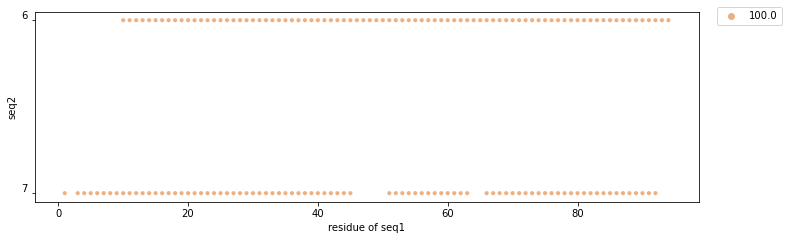

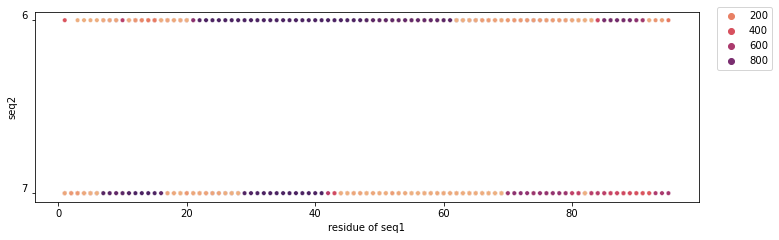

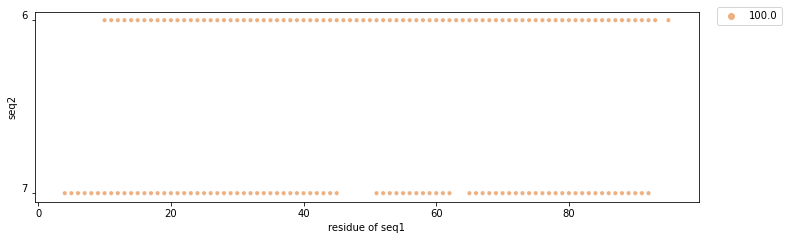

In [25]:
n = 5
plot_library(residues_sap, n)
plot_library(residues_foldseek, n)
plot_library(residues_tm_unify, n)


<AxesSubplot:xlabel='res2', ylabel='seq1'>

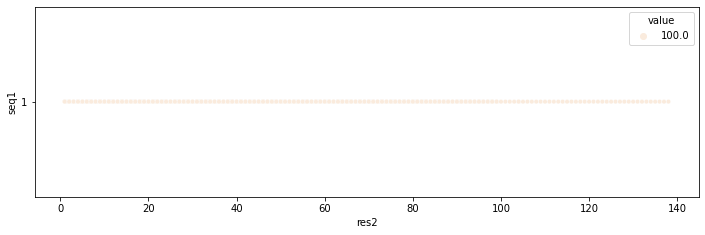

In [193]:
   f, ax = plt.subplots(figsize=(17*size_fig,5*size_fig ))
df = residues_sap
df.value = df.value.astype(float)
df.res2 = df.res2.astype(float)
df = df[df.seq1 == str(1)]
sns.scatterplot(data = df, x = "res2", y = "seq1", s = 20, hue = "value", palette = cmap) 


<AxesSubplot:xlabel='residue of seq1', ylabel='seq2'>

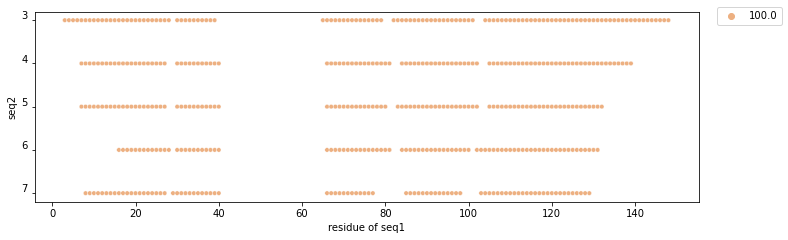

In [188]:
plot_library(residues_sap, 2)

<AxesSubplot:xlabel='residue of seq1', ylabel='seq2'>

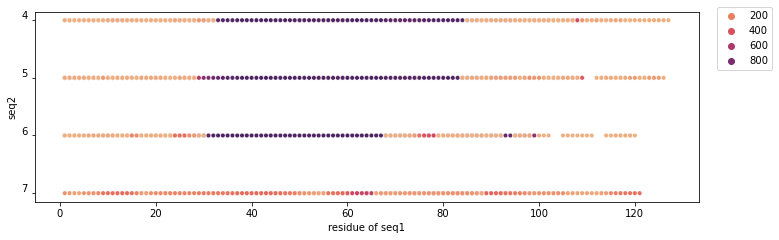

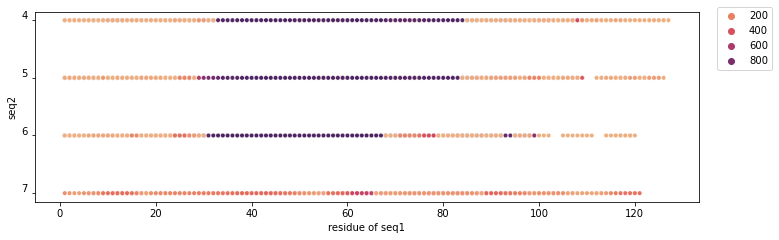

In [197]:
plot_library(residues_seq,3)
plot_library(residues_tmseq,3)

<AxesSubplot:xlabel='residue of seq1', ylabel='seq2'>

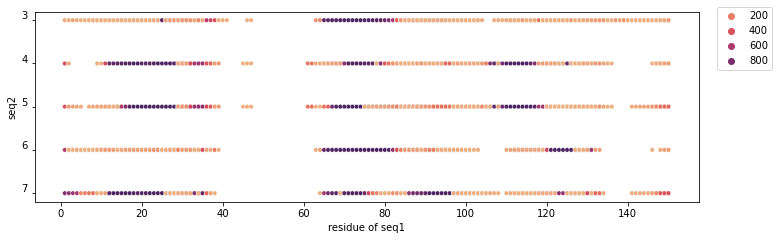

In [184]:
plot_library(residues_foldseek,2)

<AxesSubplot:xlabel='residue of seq1', ylabel='seq2'>

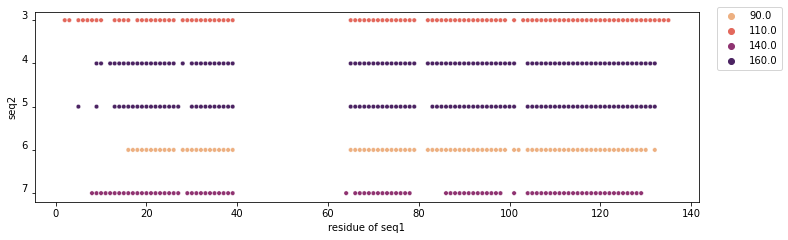

In [185]:
plot_library(residues_tmalign, 2)

<AxesSubplot:xlabel='residue of seq1', ylabel='seq2'>

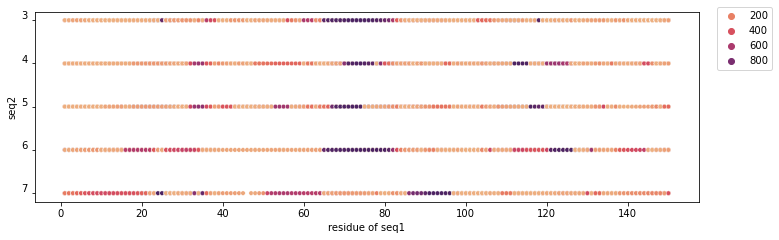

In [186]:
plot_library(residues_seqfs, 2)

<AxesSubplot:xlabel='residue of seq1', ylabel='seq2'>

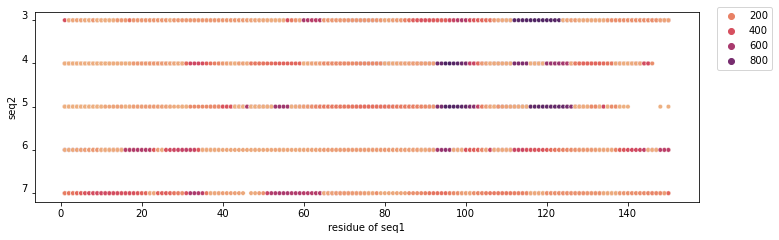

In [195]:
plot_library(residues_tmseq,2)

[Text(0.5, 0, 'residue of seq1')]

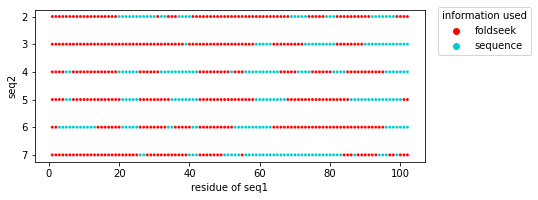

In [74]:
import warnings
warnings.filterwarnings('ignore')

size_fig = 0.7
f, ax = plt.subplots(figsize=(10*size_fig,4*size_fig ))

seq1 = "1"


#residues= residues_foldseek
#residues= pd.concat([residues_tmalign, residues_tmalign_seq,residues_seq ])
residues= pd.concat([residues_foldseek,residues_seq ])

residues.seq2 = residues.seq2.replace(r'\n','', regex=True).str.strip() 

#df = residues[(residues.seq1 == sequence) & (residues.seq2.isin(seqs))]
df = residues[(residues.seq1 == seq1)]

df.value = df.value.astype(int)
df.res1 = df.res1.astype(int)
df.res2 = df.res2.astype(int)
#df = df[df.res1 < 50 ]
df.value = df.value.astype(int)
df.value = df.value/10
df.value = df.value.astype(int).astype(float)
df["s"] = 150
df.loc[df.library=="foldseek", 's'] = 150
df.loc[df.library=="sequence", 's'] = 50

df = df.reset_index()
df['value_transformed'] = df.groupby("id")['value'].transform('max')

# group the data by 'group' and find the index of the max value for each group
idx = df.groupby(['res1', "seq2"])['value_transformed'].idxmax()
# use the index to select the columns with the max values for each group
df = df.loc[idx,:]

s = df.s
ax = sns.scatterplot(data = df, x = "res1", y = "seq2", s = 10, hue = "library", palette = ["red", "#00CCCC"]) 
ax.legend(bbox_to_anchor=(1.02, 1.05), title = "information used")
ax.set(xlabel = "residue of seq1")

In [66]:
# FILE FOR PYMOL 
df = df[df.seq2 == "4"]
result = df[["res1", "library"]]
#result["res1"] = result["res2"]
result = result[["res1", "library"]]
result.to_csv("/home/luisasantus/Desktop/test.death.csv", index = False)

In [ ]:
# EXAMPLE PARSING AND MOD LIB 